<a href="https://colab.research.google.com/github/D03S08/COVID-19-Project/blob/main/covid19_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Library

In [ ]:
!pip install --upgrade scikit-learn
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
from fbprophet.plot import plot_plotly, plot_components_plotly
import numpy as np
import datetime as dt
from datetime import timedelta, date
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from fbprophet import Prophet
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.stattools import adfuller
from sklearn import set_config
# set_config(display='diagram')

Membaca File


In [ ]:
data1 = pd.read_csv('https://raw.githubusercontent.com/D03S08/COVID-19-Project/main/2021_ID_Region_Mobility_Report.csv').iloc[12:216,8:].reset_index(drop=True)
data2 = pd.read_csv('https://raw.githubusercontent.com/D03S08/COVID-19-Project/main/COVID-19%20di%20Indonesia%20%40kawalcovid19%20-%20Statistik%20Harian.csv').iloc[316:520].reset_index(drop=True)

Mengolah data

In [ ]:
data = pd.concat([data1,data2],axis=1)
data.head()

,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,Unnamed: 0,Kasus harian,Kasus Impor,Kasus Lokal,Total kasus,Kasus aktif,% kasus aktif,Sembuh\n(baru),Sembuh,Tingkat kesembuhan (seluruh kasus),Tingkat kesembuhan (closed cases),Meninggal\n(baru),Meninggal\nDunia,Tingkat kematian (seluruh kasus),Tingkat kematian (closed cases),PDP,ODP,Suspek aktif,Jumlah spesimen diperiksa (dari 1 April),Jumlah orang diperiksa,Negatif,Positif \n(=C),Dalam Proses,Spesimen,Spesimen (PCR-TCM),Spesimen (Antigen),Orang yang dites,Orang yang dites (PCR-TCM),Orang yang dites (Antigen),Vaksinasi (ineligible),Jumlah test/juta penduduk,Test/Positif,Jumlah org yg dites / positif,...,Jumlah orang diperiksa (rata-rata 7 hari),Rasio spesimen/orang diperiksa (rata-rata 7 hari),Unnamed: 41,Dosis pertama,Dosis kedua,Dosis pertama (%),Dosis kedua (%),Dosis pertama (harian),Dosis kedua (harian),Dosis pertama (mingguan),Dosis kedua (mingguan),Dosis pertama (SDM kesehatan),Dosis kedua (SDM kesehatan),Dosis pertama (SDM kesehatan) %,Dosis kedua (SDM kesehatan) %,Dosis pertama (petugas publik),Dosis kedua (petugas publik),Dosis pertama (petugas publik) %,Dosis kedua (petugas publik) %,Dosis pertama (lansia),Dosis kedua (lansia),Dosis pertama (lansia) %,Dosis kedua (lansia) %,Dosis pertama (warga umum),Dosis kedua (warga umum),Dosis pertama (remaja),Dosis kedua (remaja),Test PCR Orang Nasional Rata-rata 7 hari,Pos Rate Nasional - rata-rata 7 hari,Test Orang DKI,Positif DKI,Unnamed: 70,Pos Rate DKI,Pos Rate DKI - 7 harian,NON DKI,Positif Non DKI,Unnamed: 75,Pos Rate Non DKI,Pos Rate Non DKI - 7 harian,CFR
0,2021-01-13,-23,-8,-19,-38.0,-29,10,13-Jan,"11,278",NaN,NaN,"858,043","129,628",15.11%,"7,657","703,464",81.98%,96.57%,306,"24,951",2.91%,3.43%,NaN,NaN,"59,667","8,063,068","5,380,137","4,522,094",NaN,NaN,"71,689",NaN,NaN,"46,977",NaN,NaN,NaN,"19,926",9.40,6.27,...,"39,160",1.52,NaN,66,NaN,0.00%,NaN,66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.02%
1,2021-01-14,-25,-12,-24,-41.0,-33,10,14-Jan,"11,557",NaN,NaN,"869,600","133,149",15.31%,"7,741","711,205",81.79%,96.57%,295,"25,246",2.90%,3.43%,NaN,NaN,"64,032","8,133,444","5,426,234","4,556,634",NaN,NaN,"70,376",NaN,NaN,"46,097",NaN,NaN,NaN,"20,097",9.35,6.24,...,"39,347",1.53,NaN,"7,760",NaN,0.00%,NaN,"7,694",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.10%
2,2021-01-15,-30,-18,-30,-45.0,-34,10,15-Jan,"12,818",NaN,NaN,"882,418","138,238",15.67%,"7,491","718,696",81.45%,96.58%,238,"25,484",2.89%,3.42%,NaN,NaN,"66,573","8,206,401","5,475,700","4,593,282",NaN,NaN,"72,957",NaN,NaN,"49,466",NaN,NaN,NaN,"20,280",9.30,6.21,...,"40,327",1.51,NaN,"18,958",NaN,0.01%,NaN,"11,198",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.13%
3,2021-01-16,-32,-19,-36,-44.0,-28,9,16-Jan,"14,224",NaN,NaN,"896,642","143,517",16.01%,"8,662","727,358",81.12%,96.58%,283,"25,767",2.87%,3.42%,NaN,NaN,"69,414","8,269,701","5,521,058","4,624,416",NaN,NaN,"63,300",NaN,NaN,"45,358",NaN,NaN,NaN,"20,448",9.22,6.16,...,"41,162",1.50,NaN,"24,414",NaN,0.01%,NaN,"5,456",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.15%
4,2021-01-17,-32,-19,-30,-44.0,-21,9,17-Jan,"11,287",NaN,NaN,"907,929","145,482",16.02%,"9,102","736,460",81.11%,96.59%,220,"25,987",2.86%,3.41%,NaN,NaN,"73,243","8,315,839","5,555,428","4,647,499",NaN,NaN,"46,138",NaN,NaN,"34,370",NaN,NaN,NaN,"20,576",9.16,6.12,...,"41,538",1.49,NaN,"24,540",NaN,0.01%,NaN,126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [ ]:
data.columns

Index(['date', 'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'Unnamed: 0',
       'Kasus harian', 'Kasus Impor', 'Kasus Lokal', 'Total kasus',
       'Kasus aktif', '% kasus aktif', 'Sembuh\n(baru)', 'Sembuh',
       'Tingkat kesembuhan (seluruh kasus)',
       'Tingkat kesembuhan (closed cases)', 'Meninggal\n(baru)',
       'Meninggal\nDunia', 'Tingkat kematian (seluruh kasus)',
       'Tingkat kematian (closed cases)', 'PDP', 'ODP', 'Suspek aktif',
       'Jumlah spesimen diperiksa (dari 1 April)', 'Jumlah orang diperiksa',
       'Negatif', 'Positif \n(=C)', 'Dalam Proses', 'Spesimen',
       'Spesimen (PCR-TCM)', 'Spesimen (Antigen)', 'Orang yang dites',
       'Orang yang dites (PCR-TCM)', 'Orang yang dites (Antigen

In [ ]:
data.rename(columns={'date':'tanggal', 'retail_and_recreation_percent_change_from_baseline':'retail dan rekreasi',
       'grocery_and_pharmacy_percent_change_from_baseline':'toko dan apotek',
       'parks_percent_change_from_baseline':'taman',
       'transit_stations_percent_change_from_baseline':'stasiun transit',
       'workplaces_percent_change_from_baseline':'tempat kerja',
       'residential_percent_change_from_baseline':'perumahan','Unnamed: 75':'a',
       'Unnamed: 70':'b','Unnamed: 41':'c','Unnamed: 0':'d'},inplace=True)

In [ ]:
pd.options.display.max_rows=86
data.isna().sum()

tanggal                                                0
retail dan rekreasi                                    0
toko dan apotek                                        0
taman                                                  0
stasiun transit                                        0
tempat kerja                                           0
perumahan                                              0
d                                                      0
Kasus harian                                           0
Kasus Impor                                          204
Kasus Lokal                                          204
Total kasus                                            0
Kasus aktif                                            0
% kasus aktif                                          0
Sembuh\n(baru)                                         0
Sembuh                                                 0
Tingkat kesembuhan (seluruh kasus)                     0
Tingkat kesembuhan (closed case

In [ ]:
data.drop(['Kasus Impor', 'Kasus Lokal','PDP','ODP','Positif \n(=C)', 'Dalam Proses',
          'Test PCR Orang Nasional Rata-rata 7 hari','Pos Rate Nasional - rata-rata 7 hari', 'Test Orang DKI', 'Positif DKI',
          'Pos Rate DKI', 'Pos Rate DKI - 7 harian', 'NON DKI', 'Positif Non DKI', 
          'Pos Rate Non DKI','Pos Rate Non DKI - 7 harian','a','b','c','d'],axis=1,inplace=True)

In [ ]:
data.loc[data['tanggal'] == '2021-01-01', 'tanggal'] = '2021-08-01'
data.loc[data['tanggal'] == '2021-01-02', 'tanggal'] = '2021-08-02'
data.loc[data['tanggal'] == '2021-01-03', 'tanggal'] = '2021-08-03'
data.loc[data['tanggal'] == '2021-01-04', 'tanggal'] = '2021-08-04'

In [ ]:
def hapus_koma(koma):
  data[koma] = data[koma].str.replace(r',', '')

list = ['Kasus harian','Total kasus','Kasus aktif','Sembuh\n(baru)',
       'Sembuh','Meninggal\nDunia','Suspek aktif',
       'Jumlah spesimen diperiksa (dari 1 April)', 'Jumlah orang diperiksa',
       'Negatif', 'Spesimen', 'Spesimen (PCR-TCM)', 'Spesimen (Antigen)',
       'Orang yang dites', 'Orang yang dites (PCR-TCM)',
       'Orang yang dites (Antigen)', 'Vaksinasi (ineligible)',
       'Jumlah test/juta penduduk','Jumlah spesimen diperiksa (rata-rata 7 hari)',
       'Jumlah orang diperiksa (rata-rata 7 hari)','Dosis pertama',
       'Dosis kedua','Dosis pertama (harian)', 'Dosis kedua (harian)',
       'Dosis pertama (mingguan)', 'Dosis kedua (mingguan)',
       'Dosis pertama (SDM kesehatan)', 'Dosis kedua (SDM kesehatan)',
       'Dosis pertama (petugas publik)', 'Dosis kedua (petugas publik)',
       'Dosis pertama (lansia)', 'Dosis kedua (lansia)',
       'Dosis pertama (warga umum)', 'Dosis kedua (warga umum)',
       'Dosis pertama (remaja)', 'Dosis kedua (remaja)']

for i in list:  
  hapus_koma(i)
data

,tanggal,retail dan rekreasi,toko dan apotek,taman,stasiun transit,tempat kerja,perumahan,Kasus harian,Total kasus,Kasus aktif,% kasus aktif,Sembuh\n(baru),Sembuh,Tingkat kesembuhan (seluruh kasus),Tingkat kesembuhan (closed cases),Meninggal\n(baru),Meninggal\nDunia,Tingkat kematian (seluruh kasus),Tingkat kematian (closed cases),Suspek aktif,Jumlah spesimen diperiksa (dari 1 April),Jumlah orang diperiksa,Negatif,Spesimen,Spesimen (PCR-TCM),Spesimen (Antigen),Orang yang dites,Orang yang dites (PCR-TCM),Orang yang dites (Antigen),Vaksinasi (ineligible),Jumlah test/juta penduduk,Test/Positif,Jumlah org yg dites / positif,Jumlah Test/Positif harian,Positif / Jumlah Tes,Positive rate harian,Case Growth Rate,Tingkat positivitas mingguan,Jumlah spesimen diperiksa (rata-rata 7 hari),Jumlah orang diperiksa (rata-rata 7 hari),Rasio spesimen/orang diperiksa (rata-rata 7 hari),Dosis pertama,Dosis kedua,Dosis pertama (%),Dosis kedua (%),Dosis pertama (harian),Dosis kedua (harian),Dosis pertama (mingguan),Dosis kedua (mingguan),Dosis pertama (SDM kesehatan),Dosis kedua (SDM kesehatan),Dosis pertama (SDM kesehatan) %,Dosis kedua (SDM kesehatan) %,Dosis pertama (petugas publik),Dosis kedua (petugas publik),Dosis pertama (petugas publik) %,Dosis kedua (petugas publik) %,Dosis pertama (lansia),Dosis kedua (lansia),Dosis pertama (lansia) %,Dosis kedua (lansia) %,Dosis pertama (warga umum),Dosis kedua (warga umum),Dosis pertama (remaja),Dosis kedua (remaja),CFR
0,2021-01-13,-23,-8,-19,-38.0,-29,10,11278,858043,129628,15.11%,7657,703464,81.98%,96.57%,306,24951,2.91%,3.43%,59667,8063068,5380137,4522094,71689,NaN,NaN,46977,NaN,NaN,NaN,19926,9.40,6.27,4.17,15.95%,24.01%,1.33%,25.41%,59683,39160,1.52,66,NaN,0.00%,NaN,66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.02%
1,2021-01-14,-25,-12,-24,-41.0,-33,10,11557,869600,133149,15.31%,7741,711205,81.79%,96.57%,295,25246,2.90%,3.43%,64032,8133444,5426234,4556634,70376,NaN,NaN,46097,NaN,NaN,NaN,20097,9.35,6.24,3.99,16.03%,25.07%,1.35%,26.10%,60020,39347,1.53,7760,NaN,0.00%,NaN,7694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.10%
2,2021-01-15,-30,-18,-30,-45.0,-34,10,12818,882418,138238,15.67%,7491,718696,81.45%,96.58%,238,25484,2.89%,3.42%,66573,8206401,5475700,4593282,72957,NaN,NaN,49466,NaN,NaN,NaN,20280,9.30,6.21,3.86,16.12%,25.91%,1.47%,26.24%,60925,40327,1.51,18958,NaN,0.01%,NaN,11198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.13%
3,2021-01-16,-32,-19,-36,-44.0,-28,9,14224,896642,143517,16.01%,8662,727358,81.12%,96.58%,283,25767,2.87%,3.42%,69414,8269701,5521058,4624416,63300,NaN,NaN,45358,NaN,NaN,NaN,20448,9.22,6.16,3.19,16.24%,31.36%,1.61%,27.16%,61817,41162,1.50,24414,NaN,0.01%,NaN,5456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.15%
4,2021-01-17,-32,-19,-30,-44.0,-21,9,11287,907929,145482,16.02%,9102,736460,81.11%,96.59%,220,25987,2.86%,3.41%,73243,8315839,5555428,4647499,46138,NaN,NaN,34370,NaN,NaN,NaN,20576,9.16,6.12,3.05,16.34%,32.84%,1.26%,27.48%,61833,41538,1.49,24540,NaN,0.01%,NaN,126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.11%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,2021-07-31,-22,14,-29,-42.0,-16,10,37284,3409658,545447,16.00%,39372,2770092,81.24%,96.71%,"1,808",94119,2.76%,3.29%,278618,26280199,17862867,14453209,241761,128694,113067,150222,61617,88605,NaN,66159,7.71,5.24,4.03,19.09%,24.82%,1.11%,25.63%,234172,157068,1.49,47390494,20621294,17.55%,7.64%,375574,318447,435471,403308,1598200,1458319,108.81%,99.29%,25935671,11640157,149.68%,67.18%,4848613,3178242,22.50%,14.75%,14050559,4337201,957451,7375,NaN
200,2021-08-01,-11,6,20,-4.0,-54,6,30738,3440396,535135,15.55%,39446,2809538,81.66%,96.

In [ ]:
baris = ['% kasus aktif','Dosis pertama (%)', 'Dosis kedua (%)',
        'Tingkat kesembuhan (seluruh kasus)','Tingkat kesembuhan (closed cases)',
        'Tingkat kematian (seluruh kasus)','Tingkat kematian (closed cases)',
        'Positif / Jumlah Tes', 'Positive rate harian', 'Case Growth Rate',
        'Tingkat positivitas mingguan','Dosis pertama (%)', 'Dosis kedua (%)',
        'Dosis pertama (SDM kesehatan) %', 'Dosis kedua (SDM kesehatan) %',
        'Dosis pertama (petugas publik) %', 'Dosis kedua (petugas publik) %',
        'Dosis pertama (lansia) %', 'Dosis kedua (lansia) %']

In [ ]:
data[list] = data[list].astype('float64')

In [ ]:
data.dtypes

tanggal                                               object
retail dan rekreasi                                    int64
toko dan apotek                                        int64
taman                                                  int64
stasiun transit                                      float64
tempat kerja                                           int64
perumahan                                              int64
Kasus harian                                         float64
Total kasus                                          float64
Kasus aktif                                          float64
% kasus aktif                                         object
Sembuh\n(baru)                                       float64
Sembuh                                               float64
Tingkat kesembuhan (seluruh kasus)                    object
Tingkat kesembuhan (closed cases)                     object
Meninggal\n(baru)                                     object
Meninggal\nDunia        

In [ ]:
data.describe(include='all')

,tanggal,retail dan rekreasi,toko dan apotek,taman,stasiun transit,tempat kerja,perumahan,Kasus harian,Total kasus,Kasus aktif,% kasus aktif,Sembuh\n(baru),Sembuh,Tingkat kesembuhan (seluruh kasus),Tingkat kesembuhan (closed cases),Meninggal\n(baru),Meninggal\nDunia,Tingkat kematian (seluruh kasus),Tingkat kematian (closed cases),Suspek aktif,Jumlah spesimen diperiksa (dari 1 April),Jumlah orang diperiksa,Negatif,Spesimen,Spesimen (PCR-TCM),Spesimen (Antigen),Orang yang dites,Orang yang dites (PCR-TCM),Orang yang dites (Antigen),Vaksinasi (ineligible),Jumlah test/juta penduduk,Test/Positif,Jumlah org yg dites / positif,Jumlah Test/Positif harian,Positif / Jumlah Tes,Positive rate harian,Case Growth Rate,Tingkat positivitas mingguan,Jumlah spesimen diperiksa (rata-rata 7 hari),Jumlah orang diperiksa (rata-rata 7 hari),Rasio spesimen/orang diperiksa (rata-rata 7 hari),Dosis pertama,Dosis kedua,Dosis pertama (%),Dosis kedua (%),Dosis pertama (harian),Dosis kedua (harian),Dosis pertama (mingguan),Dosis kedua (mingguan),Dosis pertama (SDM kesehatan),Dosis kedua (SDM kesehatan),Dosis pertama (SDM kesehatan) %,Dosis kedua (SDM kesehatan) %,Dosis pertama (petugas publik),Dosis kedua (petugas publik),Dosis pertama (petugas publik) %,Dosis kedua (petugas publik) %,Dosis pertama (lansia),Dosis kedua (lansia),Dosis pertama (lansia) %,Dosis kedua (lansia) %,Dosis pertama (warga umum),Dosis kedua (warga umum),Dosis pertama (remaja),Dosis kedua (remaja),CFR
count,204,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,2.040000e+02,204.000000,204,204.000000,2.040000e+02,204,204,204,204.000000,204,204,204.000000,2.040000e+02,2.040000e+02,2.040000e+02,204.000000,148.000000,148.000000,204.000000,150.000000,150.000000,3.000000,204.000000,204.000000,204.000000,204,204,204,204,204,204.000000,204.000000,204.000000,2.040000e+02,1.900000e+02,204,190,2.040000e+02,190.000000,198.000000,184.000000,1.560000e+02,1.560000e+02,149,149,1.560000e+02,1.560000e+02,149,149,1.560000e+02,1.560000e+02,149,149,2.400000e+01,2.400000e+01,2.400000e+01,24.000000,64
unique,204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,179,NaN,NaN,189,53,160,NaN,34,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,179,157,191,100,186,NaN,NaN,NaN,NaN,NaN,190,168,NaN,NaN,NaN,NaN,NaN,NaN,142,142,NaN,NaN,148,148,NaN,NaN,145,130,NaN,NaN,NaN,NaN,50
top,2021-03-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.14%,NaN,NaN,91.85%,97.06%,193,NaN,2.71%,2.94%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.99,18.56%,11.21%,0.33%,12.08%,NaN,NaN,NaN,NaN,NaN,0.06%,0.00%,NaN,NaN,NaN,NaN,NaN,NaN,104.15%,95.57%,NaN,NaN,84.61%,44.84%,NaN,NaN,11.83%,0.02%,NaN,NaN,NaN,NaN,2.09%
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,2,24,3,NaN,39,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,4,3,10,3,NaN,NaN,NaN,NaN,NaN,3,3,NaN,NaN,NaN,NaN,NaN,NaN,2,3,NaN,NaN,2,2,NaN,NaN,2,4,NaN,NaN,NaN,NaN,3
mean,NaN,-14.362745,8.250000,-13.617647,-31.367647,-25.980392,7.779412,13165.696078,1.752313e+06,187483.857843,NaN,10843.691176,1.517187e+06,NaN,NaN,NaN,47641.598039,NaN,NaN,99207.039216,1.504331e+07,1.009771e+07,8.345401e+06,93600.676471,65251.831081,41756.256757,63945.161765,38076.986667,34854.620000,18758.666667,37398.946078,8.620882,5.777108,NaN,NaN,NaN,NaN,NaN,91289.553922,62461.102941,1.479902,1.474348e+07,7.802792e+06,NaN,NaN,2.377195e+05,115666.452632,240193.550505,113313.385870,1.520686e+06,1.348597e+06,NaN,NaN,1.191676e+07,5.786986e+06,NaN,NaN,3.016090e+06,1.701431e+06,NaN,NaN,1.242075e+07,3.066092e+06,6.984607e+05,7862.666667,NaN
std,NaN,9.480900,12.930327,14.353760,10.606120,11.448734,3.310733,12753.796708,6.061857e+05,136003.505677,NaN,9753.857380,4.862964e+05,NaN,NaN,NaN,16022.558392,NaN,NaN,57561.347070,4.877023e+06,3.331791e+06,2.738299e+06,59703.112811,37929.899656,28409.300366,41892.098741,24389.572785,23113.174838,9020.306942,12340.001883,0.469855,0.313079,NaN,NaN,NaN,NaN,NaN,53394.292117,38593.620620,0.083666,1.394843e+07,5.987212e+06,NaN,NaN,2.443464e+05,10807

In [ ]:
def nol(kosong):
  data[kosong] = data[kosong].fillna(0)

null = ['Spesimen (PCR-TCM)','Spesimen (Antigen)','Orang yang dites (PCR-TCM)','Orang yang dites (Antigen)',
       'Dosis kedua','Dosis kedua (harian)','Dosis pertama (mingguan)','Dosis kedua (mingguan)',
       'Dosis pertama (SDM kesehatan)','Dosis kedua (SDM kesehatan)','Dosis pertama (petugas publik)',
       'Dosis kedua (petugas publik)','Dosis pertama (lansia)','Dosis kedua (lansia)',
       'Dosis pertama (warga umum)', 'Dosis kedua (warga umum)',
       'Dosis pertama (remaja)', 'Dosis kedua (remaja)']

for k in null:
  nol(k)
data

,tanggal,retail dan rekreasi,toko dan apotek,taman,stasiun transit,tempat kerja,perumahan,Kasus harian,Total kasus,Kasus aktif,% kasus aktif,Sembuh\n(baru),Sembuh,Tingkat kesembuhan (seluruh kasus),Tingkat kesembuhan (closed cases),Meninggal\n(baru),Meninggal\nDunia,Tingkat kematian (seluruh kasus),Tingkat kematian (closed cases),Suspek aktif,Jumlah spesimen diperiksa (dari 1 April),Jumlah orang diperiksa,Negatif,Spesimen,Spesimen (PCR-TCM),Spesimen (Antigen),Orang yang dites,Orang yang dites (PCR-TCM),Orang yang dites (Antigen),Vaksinasi (ineligible),Jumlah test/juta penduduk,Test/Positif,Jumlah org yg dites / positif,Jumlah Test/Positif harian,Positif / Jumlah Tes,Positive rate harian,Case Growth Rate,Tingkat positivitas mingguan,Jumlah spesimen diperiksa (rata-rata 7 hari),Jumlah orang diperiksa (rata-rata 7 hari),Rasio spesimen/orang diperiksa (rata-rata 7 hari),Dosis pertama,Dosis kedua,Dosis pertama (%),Dosis kedua (%),Dosis pertama (harian),Dosis kedua (harian),Dosis pertama (mingguan),Dosis kedua (mingguan),Dosis pertama (SDM kesehatan),Dosis kedua (SDM kesehatan),Dosis pertama (SDM kesehatan) %,Dosis kedua (SDM kesehatan) %,Dosis pertama (petugas publik),Dosis kedua (petugas publik),Dosis pertama (petugas publik) %,Dosis kedua (petugas publik) %,Dosis pertama (lansia),Dosis kedua (lansia),Dosis pertama (lansia) %,Dosis kedua (lansia) %,Dosis pertama (warga umum),Dosis kedua (warga umum),Dosis pertama (remaja),Dosis kedua (remaja),CFR
0,2021-01-13,-23,-8,-19,-38.0,-29,10,11278.0,858043.0,129628.0,15.11%,7657.0,703464.0,81.98%,96.57%,306,24951.0,2.91%,3.43%,59667.0,8063068.0,5380137.0,4522094.0,71689.0,0.0,0.0,46977.0,0.0,0.0,NaN,19926.0,9.40,6.27,4.17,15.95%,24.01%,1.33%,25.41%,59683.0,39160.0,1.52,66.0,0.0,0.00%,NaN,66.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,3.02%
1,2021-01-14,-25,-12,-24,-41.0,-33,10,11557.0,869600.0,133149.0,15.31%,7741.0,711205.0,81.79%,96.57%,295,25246.0,2.90%,3.43%,64032.0,8133444.0,5426234.0,4556634.0,70376.0,0.0,0.0,46097.0,0.0,0.0,NaN,20097.0,9.35,6.24,3.99,16.03%,25.07%,1.35%,26.10%,60020.0,39347.0,1.53,7760.0,0.0,0.00%,NaN,7694.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,3.10%
2,2021-01-15,-30,-18,-30,-45.0,-34,10,12818.0,882418.0,138238.0,15.67%,7491.0,718696.0,81.45%,96.58%,238,25484.0,2.89%,3.42%,66573.0,8206401.0,5475700.0,4593282.0,72957.0,0.0,0.0,49466.0,0.0,0.0,NaN,20280.0,9.30,6.21,3.86,16.12%,25.91%,1.47%,26.24%,60925.0,40327.0,1.51,18958.0,0.0,0.01%,NaN,11198.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,3.13%
3,2021-01-16,-32,-19,-36,-44.0,-28,9,14224.0,896642.0,143517.0,16.01%,8662.0,727358.0,81.12%,96.58%,283,25767.0,2.87%,3.42%,69414.0,8269701.0,5521058.0,4624416.0,63300.0,0.0,0.0,45358.0,0.0,0.0,NaN,20448.0,9.22,6.16,3.19,16.24%,31.36%,1.61%,27.16%,61817.0,41162.0,1.50,24414.0,0.0,0.01%,NaN,5456.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,3.15%
4,2021-01-17,-32,-19,-30,-44.0,-21,9,11287.0,907929.0,145482.0,16.02%,9102.0,736460.0,81.11%,96.59%,220,25987.0,2.86%,3.41%,73243.0,8315839.0,5555428.0,4647499.0,46138.0,0.0,0.0,34370.0,0.0,0.0,NaN,20576.0,9.16,6.12,3.05,16.34%,32.84%,1.26%,27.48%,61833.0,41538.0,1.49,24540.0,0.0,0.01%,NaN,126.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,3.11%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,2021-07-31,-22,14,-29,-42.0,-16,10,37284.0,3409658.0,545447.0,16.00%,39372.0,2770092.0,81.24%,96.71%,"1,808",94119.0,2.76%,3.29%,278618.0,26280199.0,17862867.0,14453209.0,241761.0,128694.0,113067.0,150222.0,61617.0,88605.0,NaN,66159.0,7.71,5.24,4.03,19.09%,24.82%,1.11%,25.63%,234172.0,157068.0,1.49,47390494.0,20621294.0,17.55%,7.64%,375574.0,318447.0,435471.0,403

In [ ]:
def nol_persen(empty):
  data[empty] = data[empty].fillna('0.00%')

null_persen = ['Dosis kedua (%)','Dosis pertama (SDM kesehatan) %', 'Dosis kedua (SDM kesehatan) %',
              'Dosis pertama (petugas publik) %', 'Dosis kedua (petugas publik) %',
              'Dosis pertama (lansia) %', 'Dosis kedua (lansia) %']

for l in null_persen:
  nol_persen(l)
data

,tanggal,retail dan rekreasi,toko dan apotek,taman,stasiun transit,tempat kerja,perumahan,Kasus harian,Total kasus,Kasus aktif,% kasus aktif,Sembuh\n(baru),Sembuh,Tingkat kesembuhan (seluruh kasus),Tingkat kesembuhan (closed cases),Meninggal\n(baru),Meninggal\nDunia,Tingkat kematian (seluruh kasus),Tingkat kematian (closed cases),Suspek aktif,Jumlah spesimen diperiksa (dari 1 April),Jumlah orang diperiksa,Negatif,Spesimen,Spesimen (PCR-TCM),Spesimen (Antigen),Orang yang dites,Orang yang dites (PCR-TCM),Orang yang dites (Antigen),Vaksinasi (ineligible),Jumlah test/juta penduduk,Test/Positif,Jumlah org yg dites / positif,Jumlah Test/Positif harian,Positif / Jumlah Tes,Positive rate harian,Case Growth Rate,Tingkat positivitas mingguan,Jumlah spesimen diperiksa (rata-rata 7 hari),Jumlah orang diperiksa (rata-rata 7 hari),Rasio spesimen/orang diperiksa (rata-rata 7 hari),Dosis pertama,Dosis kedua,Dosis pertama (%),Dosis kedua (%),Dosis pertama (harian),Dosis kedua (harian),Dosis pertama (mingguan),Dosis kedua (mingguan),Dosis pertama (SDM kesehatan),Dosis kedua (SDM kesehatan),Dosis pertama (SDM kesehatan) %,Dosis kedua (SDM kesehatan) %,Dosis pertama (petugas publik),Dosis kedua (petugas publik),Dosis pertama (petugas publik) %,Dosis kedua (petugas publik) %,Dosis pertama (lansia),Dosis kedua (lansia),Dosis pertama (lansia) %,Dosis kedua (lansia) %,Dosis pertama (warga umum),Dosis kedua (warga umum),Dosis pertama (remaja),Dosis kedua (remaja),CFR
0,2021-01-13,-23,-8,-19,-38.0,-29,10,11278.0,858043.0,129628.0,15.11%,7657.0,703464.0,81.98%,96.57%,306,24951.0,2.91%,3.43%,59667.0,8063068.0,5380137.0,4522094.0,71689.0,0.0,0.0,46977.0,0.0,0.0,NaN,19926.0,9.40,6.27,4.17,15.95%,24.01%,1.33%,25.41%,59683.0,39160.0,1.52,66.0,0.0,0.00%,0.00%,66.0,0.0,0.0,0.0,0.0,0.0,0.00%,0.00%,0.0,0.0,0.00%,0.00%,0.0,0.0,0.00%,0.00%,0.0,0.0,0.0,0.0,3.02%
1,2021-01-14,-25,-12,-24,-41.0,-33,10,11557.0,869600.0,133149.0,15.31%,7741.0,711205.0,81.79%,96.57%,295,25246.0,2.90%,3.43%,64032.0,8133444.0,5426234.0,4556634.0,70376.0,0.0,0.0,46097.0,0.0,0.0,NaN,20097.0,9.35,6.24,3.99,16.03%,25.07%,1.35%,26.10%,60020.0,39347.0,1.53,7760.0,0.0,0.00%,0.00%,7694.0,0.0,0.0,0.0,0.0,0.0,0.00%,0.00%,0.0,0.0,0.00%,0.00%,0.0,0.0,0.00%,0.00%,0.0,0.0,0.0,0.0,3.10%
2,2021-01-15,-30,-18,-30,-45.0,-34,10,12818.0,882418.0,138238.0,15.67%,7491.0,718696.0,81.45%,96.58%,238,25484.0,2.89%,3.42%,66573.0,8206401.0,5475700.0,4593282.0,72957.0,0.0,0.0,49466.0,0.0,0.0,NaN,20280.0,9.30,6.21,3.86,16.12%,25.91%,1.47%,26.24%,60925.0,40327.0,1.51,18958.0,0.0,0.01%,0.00%,11198.0,0.0,0.0,0.0,0.0,0.0,0.00%,0.00%,0.0,0.0,0.00%,0.00%,0.0,0.0,0.00%,0.00%,0.0,0.0,0.0,0.0,3.13%
3,2021-01-16,-32,-19,-36,-44.0,-28,9,14224.0,896642.0,143517.0,16.01%,8662.0,727358.0,81.12%,96.58%,283,25767.0,2.87%,3.42%,69414.0,8269701.0,5521058.0,4624416.0,63300.0,0.0,0.0,45358.0,0.0,0.0,NaN,20448.0,9.22,6.16,3.19,16.24%,31.36%,1.61%,27.16%,61817.0,41162.0,1.50,24414.0,0.0,0.01%,0.00%,5456.0,0.0,0.0,0.0,0.0,0.0,0.00%,0.00%,0.0,0.0,0.00%,0.00%,0.0,0.0,0.00%,0.00%,0.0,0.0,0.0,0.0,3.15%
4,2021-01-17,-32,-19,-30,-44.0,-21,9,11287.0,907929.0,145482.0,16.02%,9102.0,736460.0,81.11%,96.59%,220,25987.0,2.86%,3.41%,73243.0,8315839.0,5555428.0,4647499.0,46138.0,0.0,0.0,34370.0,0.0,0.0,NaN,20576.0,9.16,6.12,3.05,16.34%,32.84%,1.26%,27.48%,61833.0,41538.0,1.49,24540.0,0.0,0.01%,0.00%,126.0,0.0,0.0,0.0,0.0,0.0,0.00%,0.00%,0.0,0.0,0.00%,0.00%,0.0,0.0,0.00%,0.00%,0.0,0.0,0.0,0.0,3.11%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,2021-07-31,-22,14,-29,-42.0,-16,10,37284.0,3409658.0,545447.0,16.00%,39372.0,2770092.0,81.24%,96.71%,"1,808",94119.0,2.76%,3.29%,278618.0,26280199.0,17862867.0,14453209.0,241761.0,128694.0,113067.0,150222.0,61617.0,88605.0,NaN,66159.0,7.71,5.24,4.03,19.09%,24.82%,1.11%,25.63%,234172.0,157068.0,

In [ ]:
data.isnull().sum()

tanggal                                                0
retail dan rekreasi                                    0
toko dan apotek                                        0
taman                                                  0
stasiun transit                                        0
tempat kerja                                           0
perumahan                                              0
Kasus harian                                           0
Total kasus                                            0
Kasus aktif                                            0
% kasus aktif                                          0
Sembuh\n(baru)                                         0
Sembuh                                                 0
Tingkat kesembuhan (seluruh kasus)                     0
Tingkat kesembuhan (closed cases)                      0
Meninggal\n(baru)                                      0
Meninggal\nDunia                                       0
Tingkat kematian (seluruh kasus

In [ ]:
data.head()

,tanggal,retail dan rekreasi,toko dan apotek,taman,stasiun transit,tempat kerja,perumahan,Kasus harian,Total kasus,Kasus aktif,% kasus aktif,Sembuh\n(baru),Sembuh,Tingkat kesembuhan (seluruh kasus),Tingkat kesembuhan (closed cases),Meninggal\n(baru),Meninggal\nDunia,Tingkat kematian (seluruh kasus),Tingkat kematian (closed cases),Suspek aktif,Jumlah spesimen diperiksa (dari 1 April),Jumlah orang diperiksa,Negatif,Spesimen,Spesimen (PCR-TCM),Spesimen (Antigen),Orang yang dites,Orang yang dites (PCR-TCM),Orang yang dites (Antigen),Vaksinasi (ineligible),Jumlah test/juta penduduk,Test/Positif,Jumlah org yg dites / positif,Jumlah Test/Positif harian,Positif / Jumlah Tes,Positive rate harian,Case Growth Rate,Tingkat positivitas mingguan,Jumlah spesimen diperiksa (rata-rata 7 hari),Jumlah orang diperiksa (rata-rata 7 hari),Rasio spesimen/orang diperiksa (rata-rata 7 hari),Dosis pertama,Dosis kedua,Dosis pertama (%),Dosis kedua (%),Dosis pertama (harian),Dosis kedua (harian),Dosis pertama (mingguan),Dosis kedua (mingguan),Dosis pertama (SDM kesehatan),Dosis kedua (SDM kesehatan),Dosis pertama (SDM kesehatan) %,Dosis kedua (SDM kesehatan) %,Dosis pertama (petugas publik),Dosis kedua (petugas publik),Dosis pertama (petugas publik) %,Dosis kedua (petugas publik) %,Dosis pertama (lansia),Dosis kedua (lansia),Dosis pertama (lansia) %,Dosis kedua (lansia) %,Dosis pertama (warga umum),Dosis kedua (warga umum),Dosis pertama (remaja),Dosis kedua (remaja),CFR
0,2021-01-13,-23,-8,-19,-38.0,-29,10,11278.0,858043.0,129628.0,15.11%,7657.0,703464.0,81.98%,96.57%,306,24951.0,2.91%,3.43%,59667.0,8063068.0,5380137.0,4522094.0,71689.0,0.0,0.0,46977.0,0.0,0.0,NaN,19926.0,9.40,6.27,4.17,15.95%,24.01%,1.33%,25.41%,59683.0,39160.0,1.52,66.0,0.0,0.00%,0.00%,66.0,0.0,0.0,0.0,0.0,0.0,0.00%,0.00%,0.0,0.0,0.00%,0.00%,0.0,0.0,0.00%,0.00%,0.0,0.0,0.0,0.0,3.02%
1,2021-01-14,-25,-12,-24,-41.0,-33,10,11557.0,869600.0,133149.0,15.31%,7741.0,711205.0,81.79%,96.57%,295,25246.0,2.90%,3.43%,64032.0,8133444.0,5426234.0,4556634.0,70376.0,0.0,0.0,46097.0,0.0,0.0,NaN,20097.0,9.35,6.24,3.99,16.03%,25.07%,1.35%,26.10%,60020.0,39347.0,1.53,7760.0,0.0,0.00%,0.00%,7694.0,0.0,0.0,0.0,0.0,0.0,0.00%,0.00%,0.0,0.0,0.00%,0.00%,0.0,0.0,0.00%,0.00%,0.0,0.0,0.0,0.0,3.10%
2,2021-01-15,-30,-18,-30,-45.0,-34,10,12818.0,882418.0,138238.0,15.67%,7491.0,718696.0,81.45%,96.58%,238,25484.0,2.89%,3.42%,66573.0,8206401.0,5475700.0,4593282.0,72957.0,0.0,0.0,49466.0,0.0,0.0,NaN,20280.0,9.30,6.21,3.86,16.12%,25.91%,1.47%,26.24%,60925.0,40327.0,1.51,18958.0,0.0,0.01%,0.00%,11198.0,0.0,0.0,0.0,0.0,0.0,0.00%,0.00%,0.0,0.0,0.00%,0.00%,0.0,0.0,0.00%,0.00%,0.0,0.0,0.0,0.0,3.13%
3,2021-01-16,-32,-19,-36,-44.0,-28,9,14224.0,896642.0,143517.0,16.01%,8662.0,727358.0,81.12%,96.58%,283,25767.0,2.87%,3.42%,69414.0,8269701.0,5521058.0,4624416.0,63300.0,0.0,0.0,45358.0,0.0,0.0,NaN,20448.0,9.22,6.16,3.19,16.24%,31.36%,1.61%,27.16%,61817.0,41162.0,1.50,24414.0,0.0,0.01%,0.00%,5456.0,0.0,0.0,0.0,0.0,0.0,0.00%,0.00%,0.0,0.0,0.00%,0.00%,0.0,0.0,0.00%,0.00%,0.0,0.0,0.0,0.0,3.15%
4,2021-01-17,-32,-19,-30,-44.0,-21,9,11287.0,907929.0,145482.0,16.02%,9102.0,736460.0,81.11%,96.59%,220,25987.0,2.86%,3.41%,73243.0,8315839.0,5555428.0,4647499.0,46138.0,0.0,0.0,34370.0,0.0,0.0,NaN,20576.0,9.16,6.12,3.05,16.34%,32.84%,1.26%,27.48%,61833.0,41538.0,1.49,24540.0,0.0,0.01%,0.00%,126.0,0.0,0.0,0.0,0.0,0.0,0.00%,0.00%,0.0,0.0,0.00%,0.00%,0.0,0.0,0.00%,0.00%,0.0,0.0,0.0,0.0,3.11%


In [ ]:
data3 = pd.read_csv('https://raw.githubusercontent.com/D03S08/COVID-19-Project/main/applemobilitytrends-2021-08-03.csv')
data3 = data3.loc[data3['region']=='Indonesia'].reset_index(drop=True)
data3 = data3.iloc[:,6:].transpose()

In [ ]:
data3.columns = ['driving','walking']

In [ ]:
data3.isnull().sum()

driving    3
walking    3
dtype: int64

Visualisasi Data


In [ ]:
fig=px.bar(x=data.tanggal,y=data['Kasus aktif'])
fig.update_layout(title="Distribusi Kasus Aktif",
                  xaxis_title="tanggal",yaxis_title="Jumlah Kasus",)
fig.show()

In [ ]:
fig=px.bar(x=data.tanggal,y=data['Kasus harian'])
fig.update_layout(title="Distribusi Kasus Harian",
                  xaxis_title="tanggal",yaxis_title="Jumlah Kasus",)
fig.show()

In [ ]:
fig=px.bar(x=data.tanggal,y=data['Sembuh\n(baru)'])
fig.update_layout(title="Distribusi Kasus Sembuh",
                  xaxis_title="tanggal",yaxis_title="Jumlah Sembuh",)
fig.show()

In [ ]:
fig=px.bar(x=data.tanggal,y=data['Sembuh'])
fig.update_layout(title="Distribusi Total Pasien Sembuh",
                  xaxis_title="tanggal",yaxis_title="Jumlah Sembuh",)
fig.show()

In [ ]:
fig=px.bar(x=data.tanggal,y=data['Kasus harian']-data['Sembuh\n(baru)'])
fig.update_layout(title="Tingkat Kemunculan Kasus dan Kecepatan Kesembuhan",
                  xaxis_title="tanggal",yaxis_title="Perbandingan Covid dan Sembuh",)
fig.show()

In [ ]:
fig=px.bar(x=data.tanggal,y=data['Meninggal\nDunia'])
fig.update_layout(title="Tingkat Kemunculan Kasus dan Kecepatan Kesembuhan",
                  xaxis_title="tanggal",yaxis_title="Perbandingan Covid dan Sembuh",)
fig.show()

In [ ]:
data.columns

Index(['tanggal', 'retail dan rekreasi', 'toko dan apotek', 'taman',
       'stasiun transit', 'tempat kerja', 'perumahan', 'Kasus harian',
       'Total kasus', 'Kasus aktif', '% kasus aktif', 'Sembuh\n(baru)',
       'Sembuh', 'Tingkat kesembuhan (seluruh kasus)',
       'Tingkat kesembuhan (closed cases)', 'Meninggal\n(baru)',
       'Meninggal\nDunia', 'Tingkat kematian (seluruh kasus)',
       'Tingkat kematian (closed cases)', 'Suspek aktif',
       'Jumlah spesimen diperiksa (dari 1 April)', 'Jumlah orang diperiksa',
       'Negatif', 'Spesimen', 'Spesimen (PCR-TCM)', 'Spesimen (Antigen)',
       'Orang yang dites', 'Orang yang dites (PCR-TCM)',
       'Orang yang dites (Antigen)', 'Vaksinasi (ineligible)',
       'Jumlah test/juta penduduk', 'Test/Positif',
       'Jumlah org yg dites / positif', 'Jumlah Test/Positif harian',
       'Positif / Jumlah Tes', 'Positive rate harian', 'Case Growth Rate',
       'Tingkat positivitas mingguan',
       'Jumlah spesimen diperiksa (rata-

In [ ]:
fig=px.bar(x=data.tanggal,y=data['Suspek aktif'])
fig.update_layout(title="Suspek Aktif",
                  xaxis_title="tanggal",yaxis_title="Suspek")
fig.show()

In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=data['tanggal'], y=data['Jumlah orang diperiksa'],
                    mode='lines+markers',
                    name='Diperiksa'))
fig.add_trace(go.Scatter(x=data['tanggal'], y=data['Negatif'],
                    mode='lines+markers',
                    name='Negatif'))
fig.add_trace(go.Scatter(x=data['tanggal'], y=data['Spesimen'],
                    mode='lines+markers',
                    name='Spesimen'))
fig.update_layout(title='Pemeriksaan kondisi',
                 xaxis_title="tanggal",yaxis_title="kasus",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=data['tanggal'], y=data['Spesimen (PCR-TCM)'],
                    mode='lines+markers',
                    name='PCR-TCM'))
fig.add_trace(go.Scatter(x=data['tanggal'], y=data['Spesimen (Antigen)'],
                    mode='lines+markers',
                    name='Antigen'))
fig.update_layout(title='Tes Spesimen',
                 xaxis_title="tanggal",yaxis_title="kasus",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=data['tanggal'], y=data['Jumlah spesimen diperiksa (rata-rata 7 hari)'],
                    mode='lines+markers',
                    name='Spesimen'))
fig.add_trace(go.Scatter(x=data['tanggal'], y=data['Jumlah orang diperiksa (rata-rata 7 hari)'],
                    mode='lines+markers',
                    name='Orang'))
fig.update_layout(title='Jumlah Pemeriksaan mingguan',
                 xaxis_title="tanggal",yaxis_title="kasus",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=data['tanggal'], y=data['Meninggal\n(baru)'],
                    mode='lines+markers',
                    name='Meninggal'))
fig.add_trace(go.Scatter(x=data['tanggal'], y=data['Sembuh\n(baru)'],
                    mode='lines+markers',
                    name='Sembuh'))
fig.update_layout(title='Perbandingan tingkat kesembuhan dan kematian',
                 xaxis_title="tanggal",yaxis_title="kasus",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=data['tanggal'], y=data['Dosis pertama (harian)'],
                    mode='lines+markers',
                    name='Harian'))
fig.add_trace(go.Scatter(x=data['tanggal'], y=data['Dosis pertama (mingguan)'],
                    mode='lines',
                    name='Mingguan'))
fig.update_layout(title='Perbandingan penyebaran dosis vaksin pertama',
                 xaxis_title="tanggal",yaxis_title="kasus",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=data['tanggal'], y=data['Dosis kedua (harian)'],
                    mode='lines+markers',
                    name='Harian'))
fig.add_trace(go.Scatter(x=data['tanggal'], y=data['Dosis kedua (mingguan)'],
                    mode='lines',
                    name='Mingguan'))
fig.update_layout(title='Perbandingan penyebaran dosis vaksin kedua',
                 xaxis_title="tanggal",yaxis_title="kasus",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=data['tanggal'], y=data['Dosis pertama (SDM kesehatan)'],
                    mode='lines',
                    name='SDM Kesehatan'))
fig.add_trace(go.Scatter(x=data['tanggal'], y=data['Dosis pertama (petugas publik)'],
                    mode='lines',
                    name='Petugas Publik'))
fig.add_trace(go.Scatter(x=data['tanggal'], y=data['Dosis pertama (lansia)'],
                    mode='lines',
                    name='Lansia'))
fig.add_trace(go.Scatter(x=data['tanggal'], y=data['Dosis pertama (warga umum)'],
                    mode='lines',
                    name='Warga Umum'))
fig.add_trace(go.Scatter(x=data['tanggal'], y=data['Dosis pertama (remaja)'],
                    mode='lines',
                    name='Remaja'))
fig.update_layout(title='Perbandingan penyebaran dosis vaksin pertama',
                 xaxis_title="tanggal",yaxis_title="kasus",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=data['tanggal'], y=data['Dosis kedua (SDM kesehatan)'],
                    mode='lines',
                    name='SDM Kesehatan'))
fig.add_trace(go.Scatter(x=data['tanggal'], y=data['Dosis kedua (petugas publik)'],
                    mode='lines',
                    name='Petugas Publik'))
fig.add_trace(go.Scatter(x=data['tanggal'], y=data['Dosis kedua (lansia)'],
                    mode='lines',
                    name='Lansia'))
fig.add_trace(go.Scatter(x=data['tanggal'], y=data['Dosis kedua (warga umum)'],
                    mode='lines',
                    name='Warga Umum'))
fig.add_trace(go.Scatter(x=data['tanggal'], y=data['Dosis kedua (remaja)'],
                    mode='lines',
                    name='Remaja'))
fig.update_layout(title='Perbandingan penyebaran dosis vaksin kedua',
                 xaxis_title="tanggal",yaxis_title="kasus",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

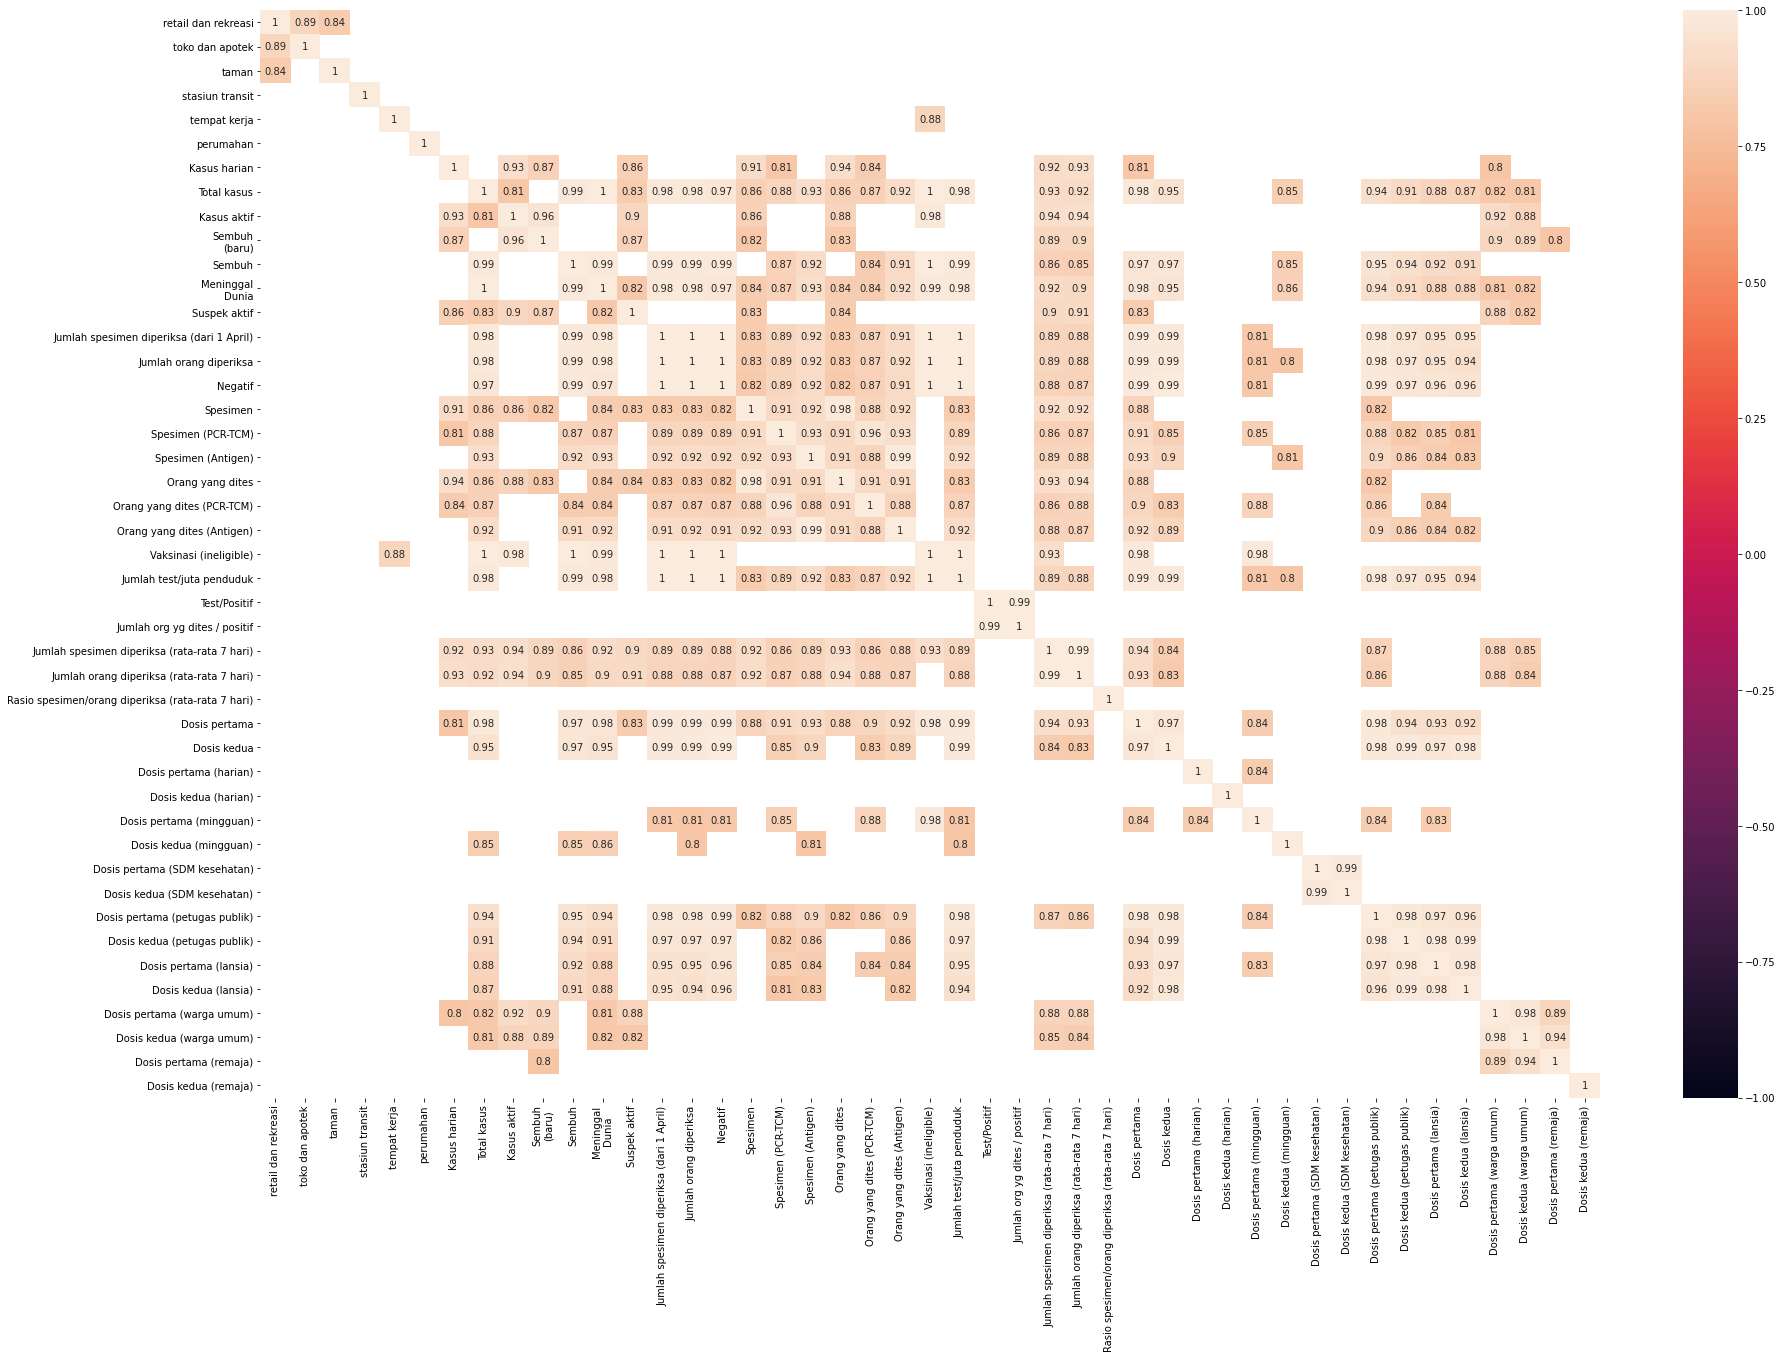

In [ ]:
fig = plt.figure(figsize=(30,20))
sns.heatmap(data.corr()[(data.corr() >= 0.8)]
            ,annot=True, vmin=-1, vmax=1);

In [ ]:
data.columns

Index(['tanggal', 'retail dan rekreasi', 'toko dan apotek', 'taman',
       'stasiun transit', 'tempat kerja', 'perumahan', 'Kasus harian',
       'Total kasus', 'Kasus aktif', '% kasus aktif', 'Sembuh\n(baru)',
       'Sembuh', 'Tingkat kesembuhan (seluruh kasus)',
       'Tingkat kesembuhan (closed cases)', 'Meninggal\n(baru)',
       'Meninggal\nDunia', 'Tingkat kematian (seluruh kasus)',
       'Tingkat kematian (closed cases)', 'Suspek aktif',
       'Jumlah spesimen diperiksa (dari 1 April)', 'Jumlah orang diperiksa',
       'Negatif', 'Spesimen', 'Spesimen (PCR-TCM)', 'Spesimen (Antigen)',
       'Orang yang dites', 'Orang yang dites (PCR-TCM)',
       'Orang yang dites (Antigen)', 'Vaksinasi (ineligible)',
       'Jumlah test/juta penduduk', 'Test/Positif',
       'Jumlah org yg dites / positif', 'Jumlah Test/Positif harian',
       'Positif / Jumlah Tes', 'Positive rate harian', 'Case Growth Rate',
       'Tingkat positivitas mingguan',
       'Jumlah spesimen diperiksa (rata-

In [ ]:
# X = data[['Total kasus','Sembuh','Meninggal\nDunia','Jumlah spesimen diperiksa (dari 1 April)', 'Jumlah orang diperiksa',
#        'Negatif','Spesimen (PCR-TCM)', 'Spesimen (Antigen)','Orang yang dites (PCR-TCM)',
#        'Orang yang dites (Antigen)','Jumlah test/juta penduduk','Jumlah spesimen diperiksa (rata-rata 7 hari)',
#        'Jumlah orang diperiksa (rata-rata 7 hari)','Dosis pertama']]
# y = data['Dosis kedua']

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, shuffle=False, random_state=42)

In [ ]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test =scaler.transform(X_test)

In [ ]:
# # !pip install --upgrade scikit-learn
# model = LinearRegression()
# model.fit(X_train,y_train)
# set_config(display='diagram')
# pred=model.predict(X_test)
# sc=np.round(model.score(X_test, y_test),2) * 100
# r2=np.round(r2_score(y_test,pred),2)
# mse=np.round(mean_squared_error(y_test,pred),2)
# mae=np.round(mean_squared_error(y_test,pred),2)

In [ ]:
# fig=plt.figure(figsize=(15,8))
# p=pd.Series(pred, index=y_test.index)
# plt.plot(y_test)
# plt.plot(p)
# plt.legend(['y_test','predicted'])
# plt.title("Compare test and predicted values", size=20, weight='bold')
# plt.text(x=800000, y=600,s='Accuracy score : {} %'.format(sc))
# plt.text(x=800000, y=580,s='R2 Score : {}'.format(r2))
# plt.text(x=800000, y=560,s='Mean Squared error : {}'.format(mse))
# plt.text(x=800000, y=540,s='Mean Absolute error : {}'.format(mae))

In [ ]:
# X = data[['Total kasus','Sembuh','Meninggal\nDunia','Jumlah spesimen diperiksa (dari 1 April)', 'Jumlah orang diperiksa',
#         'Negatif','Spesimen (PCR-TCM)', 'Spesimen (Antigen)','Orang yang dites (PCR-TCM)',
#         'Orang yang dites (Antigen)','Jumlah test/juta penduduk','Jumlah spesimen diperiksa (rata-rata 7 hari)',
#         'Jumlah orang diperiksa (rata-rata 7 hari)','Dosis pertama']]
# y = data['Dosis kedua']
# length=100
# #from sklearn.model_selection import train_test_split
# #X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=False, random_state=42)
# training_set = X.iloc[:1000].values
# test_set = X.iloc[1000:].values
# # Feature Scaling
# from sklearn.preprocessing import MinMaxScaler
# sc = MinMaxScaler(feature_range = (0, 1))
# training_set_scaled = sc.fit_transform(training_set)
# test_set_scaled=sc.transform(test_set)
# # Creating a data structure with 60 time-steps and 1 output
# X_train = []
# y_train = []
# for i in range(length, len(training_set)):
#     X_train.append(training_set_scaled[i-length:i, 0])
#     y_train.append(training_set_scaled[i, 0])
# X_train, y_train = np.array(X_train), np.array(y_train)
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# X_test = []
# y_test = []
# for i in range(length, len(test_set)):
#     X_test.append(test_set_scaled[i-length:i, 0])
#     y_test.append(test_set_scaled[i, 0])
# X_test, y_test = np.array(X_test), np.array(y_test)
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:


# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, LSTM, Dropout
# model = Sequential()
# #Adding the first LSTM layer and some Dropout regularisation
# model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# model.add(Dropout(0.2))
# # Adding a second LSTM layer and some Dropout regularisation
# model.add(LSTM(units = 50, return_sequences = True))
# model.add(Dropout(0.2))
# # Adding a third LSTM layer and some Dropout regularisation
# model.add(LSTM(units = 50, return_sequences = True))
# model.add(Dropout(0.2))
# # Adding a fourth LSTM layer and some Dropout regularisation
# model.add(LSTM(units = 50))
# model.add(Dropout(0.2))
# # Adding the output layer
# model.add(Dense(units = 1))

# # Compiling the RNN
# model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# # Fitting the RNN to the Training set
# model.fit(X_train, y_train, validation_data=(X_test,y_test),epochs = 100, batch_size = 32)

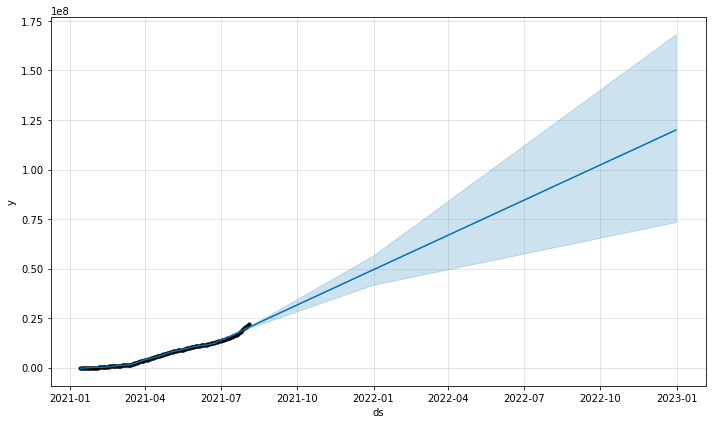

In [ ]:
df_p = data[['tanggal','Dosis kedua']]
df_p.columns=['ds','y']

model = Prophet(
    n_changepoints=25,
    changepoint_range=0.8, 
    changepoint_prior_scale=0.05,
    daily_seasonality=False, 
    weekly_seasonality=False,
    yearly_seasonality=False
    )
## add monthly seasonality
model.add_seasonality(name='monthly', period=30.5, fourier_order=1)
model.add_trace
model.fit(df_p)

# forecasting
future = model.make_future_dataframe(periods=2, freq='Y')
forecast = model.predict(future)

# visualize
fig = model.plot(forecast)

In [ ]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,monthly,monthly_lower,monthly_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-13,-6.541482e+05,-1.034440e+05,9.274062e+04,-6.541482e+05,-6.541482e+05,6.514692e+05,6.514692e+05,6.514692e+05,-2.618506e+06,-2.618506e+06,-2.618506e+06,-5840.069674,-5840.069674,-5840.069674,18278.366993,18278.366993,18278.366993,3.257537e+06,3.257537e+06,3.257537e+06,0.0,0.0,0.0,-2.678952e+03
1,2021-01-14,-5.500341e+05,-7.674309e+04,1.200684e+05,-5.500341e+05,-5.500341e+05,5.755237e+05,5.755237e+05,5.755237e+05,-2.618506e+06,-2.618506e+06,-2.618506e+06,12255.448674,12255.448674,12255.448674,31654.665597,31654.665597,31654.665597,3.150120e+06,3.150120e+06,3.150120e+06,0.0,0.0,0.0,2.548960e+04
2,2021-01-15,-4.459200e+05,-5.439166e+04,1.387064e+05,-4.459200e+05,-4.459200e+05,4.895595e+05,4.895595e+05,4.895595e+05,-2.618506e+06,-2.618506e+06,-2.618506e+06,24156.916248,24156.916248,24156.916248,40705.042363,40705.042363,40705.042363,3.043204e+06,3.043204e+06,3.043204e+06,0.0,0.0,0.0,4.363949e+04
3,2021-01-16,-3.418059e+05,-6.935734e+04,1.175982e+05,-3.418059e+05,-3.418059e+05,3.693503e+05,3.693503e+05,3.693503e+05,-2.618506e+06,-2.618506e+06,-2.618506e+06,22600.721315,22600.721315,22600.721315,28121.784978,28121.784978,28121.784978,2.937134e+06,2.937134e+06,2.937134e+06,0.0,0.0,0.0,2.754442e+04
4,2021-01-17,-2.376918e+05,-1.700399e+05,3.187586e+04,-2.376918e+05,-2.376918e+05,1.688703e+05,1.688703e+05,1.688703e+05,-2.618506e+06,-2.618506e+06,-2.618506e+06,10266.649046,10266.649046,10266.649046,-54984.010341,-54984.010341,-54984.010341,2.832094e+06,2.832094e+06,2.832094e+06,0.0,0.0,0.0,-6.882147e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,2021-10-29,2.973129e+07,2.572567e+07,2.596023e+07,2.967573e+07,2.979530e+07,-3.888918e+06,-3.888918e+06,-3.888918e+06,-2.618506e+06,-2.618506e+06,-2.618506e+06,33278.771902,33278.771902,33278.771902,40705.042363,40705.042363,40705.042363,-1.344396e+06,-1.344396e+06,-1.344396e+06,0.0,0.0,0.0,2.584237e+07
290,2021-10-30,2.983711e+07,2.645368e+07,2.669595e+07,2.978033e+07,2.990239e+07,-3.266483e+06,-3.266483e+06,-3.266483e+06,-2.618506e+06,-2.618506e+06,-2.618506e+06,16171.172025,16171.172025,16171.172025,28121.784978,28121.784978,28121.784978,-6.922696e+05,-6.922696e+05,-6.922696e+05,0.0,0.0,0.0,2.657063e+07
291,2021-10-31,2.994293e+07,2.711601e+07,2.734031e+07,2.988496e+07,3.000967e+07,-2.712144e+06,-2.712144e+06,-2.712144e+06,-2.618506e+06,-2.618506e+06,-2.618506e+06,-12792.852646,-12792.852646,-12792.852646,-54984.010341,-54984.010341,-54984.010341,-2.586137e+04,-2.586137e+04,-2.586137e+04,0.0,0.0,0.0,2.723078e+07
292,2021-11-01,3.004874e+07,2.786685e+07,2.809846e+07,2.998960e+07,3.011662e+07,-2.067171e+06,-2.067171e+06,-2.067171e+06,-2.618506e+06,-2.618506e+06,-2.618506e+06,-43534.282281,-43534.282281,-43534.282281,-45415.042806,-45415.042806,-45415.042806,6.402842e+05,6.402842e+05,6.402842e+05,0.0,0.0,0.0,2.798157e+07
